# Loading local files into Runtime
---
In this step, we extract the contents of the code zip file and upload them to the Colab runtime by clicking on the folder icon in the left hand side vertical navigation bar. Once that is done, click on the Drive icon and upload the extracted contents. 

**Make sure to select GPU as runtime type before performing this step**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd <enter path to extracted code zip files on Drive here> 

# Pre-Trained Model vs Training from Scratch
---
In order to run this experiment, we can either use the pretrained weights or train the generator and discriminator from scratch and save those weights. If you wish to train the models from scratch, skip this step. If you wish to use the pretrained weights and just demo the working of the model, you can run the following commands.

We used the `pre-generator.h5` weight and then carried out the Generator and Discriminator Fine Tuning Training for `50,000` steps.

In [ ]:
# Downloading the weights and extracting them
!wget https://martin-krasser.de/sisr/weights-srgan.tar.gz
!tar xvfz weights-srgan.tar.gz

--2021-11-22 07:06:24--  https://martin-krasser.de/sisr/weights-srgan.tar.gz
Resolving martin-krasser.de (martin-krasser.de)... 217.160.0.142, 2001:8d8:100f:f000::209
Connecting to martin-krasser.de (martin-krasser.de)|217.160.0.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99033507 (94M) [application/gzip]
Saving to: ‘weights-srgan.tar.gz.3’

weights-srgan.tar.g 100%[===================>]  94.45M  25.6MB/s    in 4.4s    

2021-11-22 07:06:29 (21.3 MB/s) - ‘weights-srgan.tar.gz.3’ saved [99033507/99033507]

weights/srgan/gan_discriminator.h5
weights/srgan/gan_generator.h5
weights/srgan/pre_generator.h5


In [ ]:
# Keeping only the pre-generator.h5 weight
# Comment out below lines if you want to use all of the predefined weights and 
# not train from scratch

%cd weights/srgan
!rm gan_generator.h5 gan_discriminator.h5
%cd ..
%cd ..

## Setting the path for the weights for loading and saving
---
In this block, we set the file path for the weights folder to make it easier to save and load the weights and access them for visualization later on

In [ ]:
import os

weights_dir = 'weights/srgan'
weights_file = lambda filename: os.path.join(weights_dir, filename)

os.makedirs(weights_dir, exist_ok = True)

# Creating training and validation batches
---
We now create the train and test batches using the DIV2K class and apply a downgrade of scale $4 \times$ using bicubic interpolation. This step also downloads the DIV2K dataset to your root folder to the `.div2k/` folder. Make sure you have enough space in your Google Drive before running this block

In [ ]:
from div2k import *
from utils.utils import *
from train import *

div2k_train = DIV2K(scale = 4, subset = 'train', downgrade = 'bicubic')
div2k_test = DIV2K(scale = 4, subset = 'valid', downgrade = 'bicubic')

train_dataset = div2k_train.dataset(batch_size = 16, random_transform = True)
test_dataset = div2k_test.dataset(batch_size = 16, random_transform = True, repeat_count = 1)

Caching decoded images in .div2k/caches/DIV2K_train_HR.cache ...
Cached decoded images in .div2k/caches/DIV2K_train_HR.cache.
31514624/31505881 [==============================] - 2s 0us/step
Caching decoded images in .div2k/caches/DIV2K_valid_LR_bicubic_X4.cache ...
Cached decoded images in .div2k/caches/DIV2K_valid_LR_bicubic_X4.cache.
449003520/448993893 [==============================] - 29s 0us/step
Caching decoded images in .div2k/caches/DIV2K_valid_HR.cache ...
Cached decoded images in .div2k/caches/DIV2K_valid_HR.cache.


# Fine Tuning the Generator Training
---
In this step, we fine tune the generator training using the `pre_generator.h5` weight that we downloaded earlier. We train the GAN for `50,000` steps. The number of steps can be changed to be higher or lower as per your preference.

In [ ]:
from model.SRGAN import *
from train import *

GAN_generator = generator()
GAN_generator.load_weights(weights_file('pre_generator.h5'))

GAN_trainer = SrganTrainer(generator = GAN_generator, discriminator = Discriminator())
GAN_trainer.train(train_dataset, steps = 50000)

50/50000, perceptual loss = 0.0782, discriminator loss = 1.9576
100/50000, perceptual loss = 0.0693, discriminator loss = 1.4094
150/50000, perceptual loss = 0.0731, discriminator loss = 1.2726
200/50000, perceptual loss = 0.0803, discriminator loss = 0.7874
250/50000, perceptual loss = 0.0789, discriminator loss = 0.7032
300/50000, perceptual loss = 0.0787, discriminator loss = 1.0409
350/50000, perceptual loss = 0.0770, discriminator loss = 1.1668
400/50000, perceptual loss = 0.0780, discriminator loss = 0.8254
450/50000, perceptual loss = 0.0778, discriminator loss = 0.5115
500/50000, perceptual loss = 0.0801, discriminator loss = 0.8648
550/50000, perceptual loss = 0.0769, discriminator loss = 0.5477
600/50000, perceptual loss = 0.0755, discriminator loss = 0.8650
650/50000, perceptual loss = 0.0765, discriminator loss = 0.6557
700/50000, perceptual loss = 0.0796, discriminator loss = 0.2684
750/50000, perceptual loss = 0.0778, discriminator loss = 0.8574
800/50000, perceptual loss

## Saving the weights
---
Now, we save the generator and discriminator weights to access them for visualization later on

In [ ]:
GAN_trainer.generator.save_weights(weights_file('gan_generator.h5'))
GAN_trainer.discriminator.save_weights(weights_file('gan_discriminator.h5'))

# Visualizing the results
---


In [ ]:
pre_generator = generator()
GAN_generator = generator()

pre_generator.load_weights(weights_file('pre_generator.h5'))
GAN_generator.load_weights(weights_file('gan_generator.h5'))

In [ ]:
from utils.visualize import *

def ResolveAndPlot(lowres_image_path):
    lowres = LoadImage(lowres_image_path)
    
    pre_superres = ResolveSingleImage(pre_generator, lowres)
    GAN_superres = ResolveSingleImage(GAN_generator, lowres)
    
    plt.figure(figsize=(30, 30))
    
    images = [lowres, pre_superres, GAN_superres]
    titles = ['Low Resolution', 'Original', '4X SRGAN']
    positions = [1, 2, 3]
    
    for i, (img, title, pos) in enumerate(zip(images, titles, positions)):
        plt.subplot(2, 3, pos)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

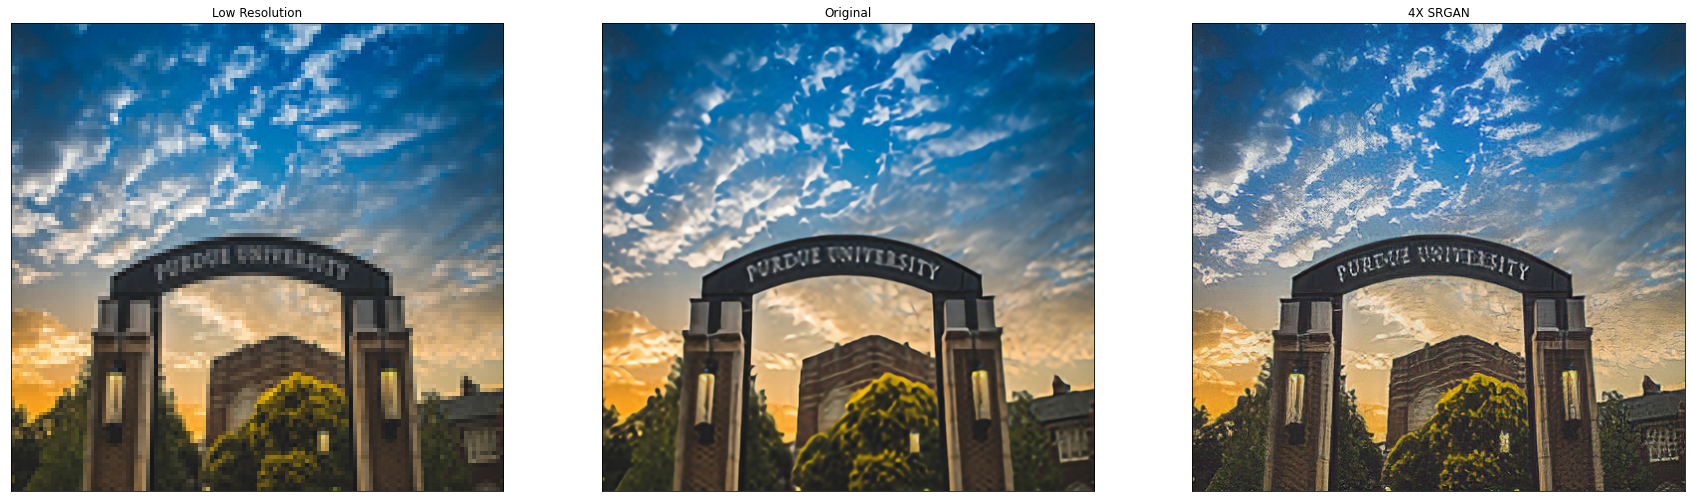

In [ ]:
ResolveAndPlot("demo/gateway-cropped.png")